In [1]:
import os
import json

import numpy as np
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt

import tools

# Pandas to display 3 decimal points
pd.options.display.float_format = '{:.3f}'.format
# Make matplotlib interractive in jupyter
%matplotlib widget

In [2]:
def plot_est(state_df, sample_rate, title):
    t = np.arange(len(state_df))/sample_rate
    # Plot the estimated locations, and angles over time, with time axis in seconds, in 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
    fig.suptitle(title)
    ax1.plot(t, state_df['x_w'], 'r', label='x')
    ax1.plot(t, state_df['y_w'], 'g', label='y')
    ax1.plot(t, state_df['z_w'], 'b', label='z')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Location (m)')
    ax2.plot(t, state_df['pi_w']/(2*np.pi)*360, 'r', label='pitch')
    ax2.plot(t, state_df['ro_w']/(2*np.pi)*360, 'g', label='roll')
    ax2.plot(t, state_df['ya_w']/(2*np.pi)*360, 'b', label='yaw')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (deg)')
    plt.tight_layout()
    plt.show()


def run_location_tests(accelerometer, gyroscope, sample_rate, trackers: dict, plot_distance=True, plot_time=False):
    for i in range(len(accelerometer)):
        for tracker_name in trackers:
            trackers[tracker_name].add_measurement(accelerometer[i], gyroscope[i])

    df_list = [trackers[tracker_name].get_state_history_df() for tracker_name in trackers]
    # Print final locations
    # for tracker_name, df in zip(trackers, df_list):
    #     print(f'{tracker_name} Final Location: {df.iloc[-1]["x_w"]:0.3f}, {df.iloc[-1]["y_w"]:0.3f}, {df.iloc[-1]["z_w"]:0.3f}')

    if plot_distance:
        # Plot the estimated locations over time, with time axis in seconds
        plt.figure()
        for tracker_name, df in zip(trackers, df_list):
            plt.plot(df['x_w'].to_numpy(), df['y_w'].to_numpy(), label=tracker_name)
        plt.legend(loc='upper left')
        plt.xlabel('x position (m)')
        plt.ylabel('y position (m)')
        plt.tight_layout()
        plt.show()

    if plot_time:
        for tracker_name, df in zip(trackers, df_list):
            plot_est(df, sample_rate, tracker_name)

def test_file(file, calibration, plot_time=False, plot_distance=False, plot_data=False, settle_time=3):
    accelerometer, gyroscope, sample_rate, temperature, temperature_sample_rate = tools.read_data_file(
        os.path.join('..', 'tmp', file), lowpass=150, settle_time=settle_time
    )
    # Implement calibration
    accelerometer, gyroscope = tools.apply_calibration(accelerometer, gyroscope, temperature, calibration)

    # Get initial rotation
    init_r = tools.Location3d.initial_rotation_from_accelerometer(accelerometer, sample_rate, length=0.25)

    if plot_data:
        tools.plot_data(accelerometer, gyroscope, sample_rate, f'{os.path.basename(file)}', temperature, temperature_sample_rate)
        tools.plot_data(init_r.apply(accelerometer), gyroscope, sample_rate, f'Rotated: {os.path.basename(file)}', temperature, temperature_sample_rate)

    # Process noise covariance (Too slow to react? Increase Q; Too sensitive to noise? Decrease the Q)
    config = tools.UkfConfig(
        state_n=len(tools.Location3d.state_names), measurement_n=6,
        alpha=1e-3, beta=2, kappa=0,
        Q=1e-4, P=1e-6, R=np.array(calibration['R']),
        init_r=init_r
    )
    # ukf_obj = tools.Location3dUkf(sample_rate=sample_rate, config=config)
    dr_obj = tools.Location3d(sample_rate=sample_rate, init_r=init_r)
    # dr_obj = tools.Location3d(sample_rate=sample_rate, init_r=init_r.inv())

    run_location_tests(
        # accelerometer, gyroscope, sample_rate, {'ukf': ukf_obj, 'dr': dr_obj}, plot_time=True
        accelerometer, gyroscope, sample_rate, {'dr': dr_obj}, plot_time=plot_time, plot_distance=plot_distance,
    )
    dr_df = dr_obj.get_state_history_df()
    final_x = dr_df.iloc[-1]["x_w"]
    final_y = dr_df.iloc[-1]["y_w"]
    final_z = dr_df.iloc[-1]["z_w"]

    init_euler = init_r.as_euler('xyz', degrees=True)

    # Calculate the integral of the rotated accelerometer vector to get an ideal velocity and distance
    rotated_accelerometer = init_r.apply(accelerometer)
    velocity = np.cumsum(rotated_accelerometer - np.array([0, 0, tools.GRAVITY]), axis=0) / sample_rate
    distance = np.cumsum(velocity, axis=0) / sample_rate

    return {
        'file': os.path.basename(file),
        'temperature': np.mean(temperature),
        'init_pitch': init_euler[0],
        'init_roll': init_euler[1],
        'init_yaw': init_euler[2],
        'mag_a': np.mean(np.linalg.norm(accelerometer, axis=1)),
        'final_x': final_x,
        'final_y': final_y,
        'final_z': final_z,
        'distance': np.linalg.norm([final_x, final_y, final_z]),
        'distance_sum': np.linalg.norm(distance[-1]),
        'xy_distance': np.linalg.norm([final_x, final_y]),
        'xy_distance_sum': np.linalg.norm(distance[-1][0:2]),
    }

In [3]:
# Read calibration data
file = 'calibration.json'
with open(file) as f:
    calibration = json.load(f)

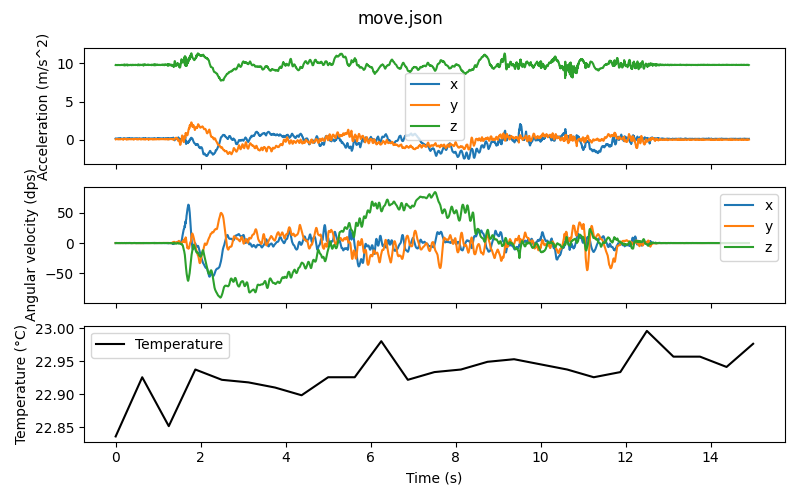

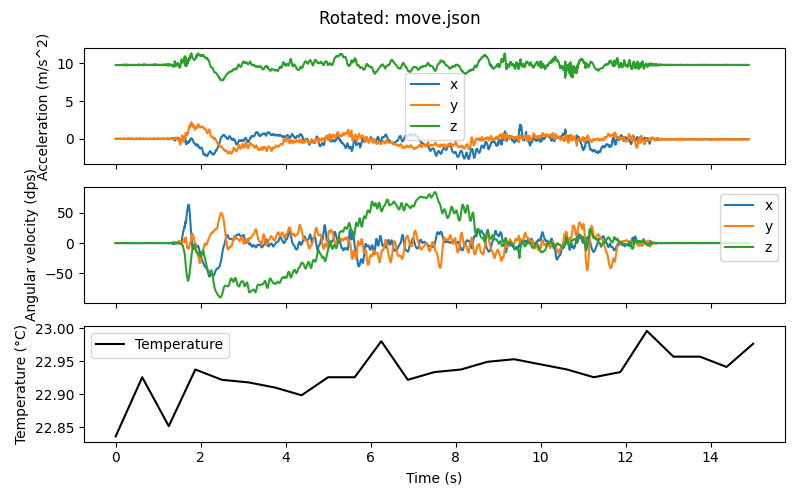

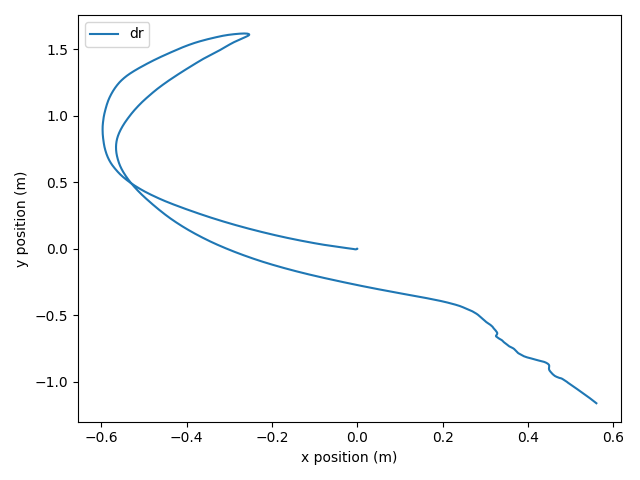

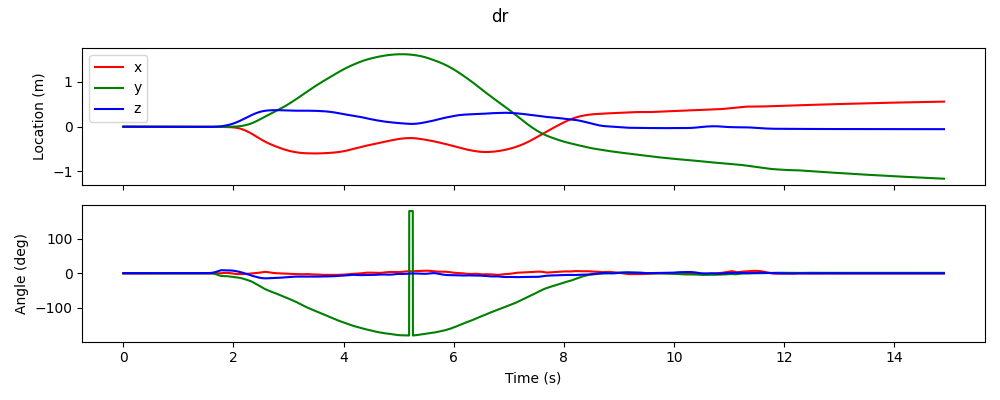

{'file': 'move.json',
 'temperature': 22.931875,
 'init_pitch': 0.34832309933201083,
 'init_roll': -0.7674193276276028,
 'init_yaw': -3.8828613245550705e-19,
 'mag_a': 9.831823356011046,
 'final_x': 0.5602165707047587,
 'final_y': -1.161638779491776,
 'final_z': -0.055020892765198656,
 'distance': 1.290842577060434,
 'distance_sum': 39.061323296927135,
 'xy_distance': 1.2896694383101985,
 'xy_distance_sum': 38.97874596729592}

In [4]:
test_file('test_5v/move.json', calibration, plot_time=True, plot_distance=True, plot_data=True, settle_time=0.1)
# test_file('cal_5v/cal_31.json', calibration, plot_time=True, plot_distance=True, plot_data=True)

In [5]:
cal_path = os.path.join('..', 'tmp', 'cal_5v')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

df = []
for file in file_names:
    df.append(test_file(file, calibration))
df = pd.DataFrame(df)

temperature        1.000
init_pitch        -0.390
xy_distance        0.334
distance           0.331
init_roll         -0.194
distance_sum       0.168
mag_a             -0.147
final_z           -0.145
xy_distance_sum    0.119
final_x            0.118
init_yaw           0.091
final_y            0.086
Name: temperature, dtype: float64

,file,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
0,cal_1.json,24.544,-179.652,-16.915,0.000,9.814,-0.201,0.260,0.771,0.838,0.788,0.329,0.164
1,cal_10.json,23.953,0.473,13.312,0.000,9.794,0.133,0.135,-0.612,0.641,0.615,0.189,0.060
2,cal_11.json,23.899,0.960,35.981,0.000,9.801,0.328,0.578,-0.197,0.694,0.250,0.665,0.154
3,cal_12.json,23.799,-0.443,-34.929,0.000,9.807,0.049,0.014,0.258,0.263,0.271,0.051,0.085
4,cal_13.json,23.805,-1.529,-59.202,0.000,9.809,-0.002,0.183,0.416,0.454,0.422,0.183,0.071
5,cal_14.json,22.710,-5.689,0.266,0.000,9.804,0.139,0.098,0.031,0.173,0.097,0.170,0.092
6,cal_15.json,22.830,-17.175,0.326,0.000,9.803,-0.100,-0.107,-0.027,0.149,0.146,0.147,0.144
7,cal_16.json,22.963,-29.073,0.282,0.000,9.806,0.087,-0.089,0.232,0.263,0.307,0.125,0.201
8,cal_17.json,23.114,-45.740,0.603,-0.000,9.806,-0.180,0.123,0.174,0.279,0.202,0.218,0.102
9,cal_18.json,23.450,-65.898,0.835,-0.000,9.805,0.011,-0.003,0.009,0.014,0.010,0.012,0.005


,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
count,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000
mean,24.188,-4.554,1.043,0.000,9.803,0.025,0.006,0.001,0.493,0.385,0.312,0.138
std,0.869,106.835,35.686,0.000,0.006,0.221,0.297,0.418,0.254,0.236,0.196,0.111
min,22.710,-179.652,-72.372,-0.000,9.790,-0.683,-0.831,-0.917,0.014,0.010,0.010,0.005
25%,23.483,-81.037,-22.084,-0.000,9.801,-0.089,-0.189,-0.181,0.263,0.198,0.164,0.060
50%,24.095,-5.689,0.194,0.000,9.803,-0.002,0.035,-0.012,0.470,0.330,0.287,0.102
75%,24.528,47.766,24.449,0.000,9.808,0.161,0.186,0.322,0.672,0.517,0.435,0.183
max,27.140,179.832,67.608,0.000,9.817,0.523,0.578,0.950,1.084,0.959,0.982,0.485


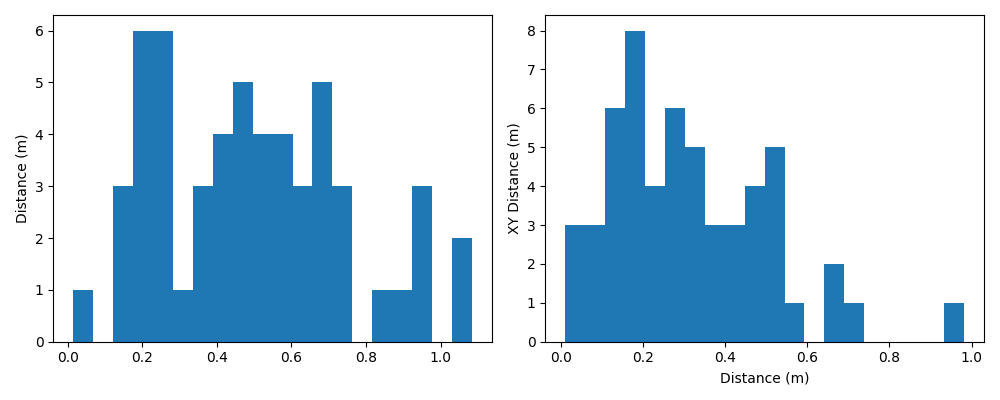

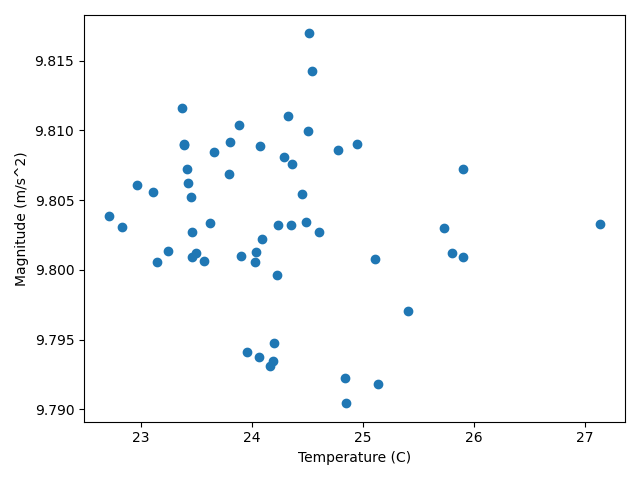

In [6]:
# Get the cross correlation for temperature in the dataframe
corr = df.drop(columns=['file']).corr()
# Display sorted by absolute value
display(corr['temperature'].sort_values(key=lambda x: np.abs(x), ascending=False))

display(df)
display(df.describe())

# Display a historgram of the distance and the xy_distance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(df['distance'], bins=20)
ax1.set_ylabel('Distance (m)')
ax2.hist(df['xy_distance'], bins=20)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('XY Distance (m)')
plt.tight_layout()
plt.show()

# Display distance vs temperature
plt.figure()
plt.plot(df['temperature'], df['mag_a'], 'o')
plt.xlabel('Temperature (C)')
plt.ylabel('Magnitude (m/s^2)')
plt.tight_layout()
plt.show()

In [7]:
cal_path = os.path.join('..', 'tmp', 'test_5v')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

test_df = []
for file in file_names:
    test_df.append(test_file(file, calibration))
test_df = pd.DataFrame(test_df)
display(test_df)

,file,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
0,move.json,22.940,-5.126,0.254,-0.000,9.832,22.622,-83.874,-5.153,87.024,43.557,86.871,43.503
1,static_table.json,23.718,0.074,1.614,-0.000,9.794,-0.163,1.935,-3.339,3.862,3.349,1.942,0.269
2,table_test.json,21.261,0.321,0.182,0.000,9.799,3.169,0.869,-1.510,3.616,1.571,3.286,0.442
